In [1]:
# ====== SETTINGS ======
from google.colab import drive
drive.mount('/content/drive')
DATA_DIR = "/content/drive/MyDrive/traffic_sign_recognition/data"    # <-- change this to your dataset root (folder containing meta/, train/, test/ and CSVs)
IMG_SIZE = 128                # image size (square). MobileNetV2 supports sizes >= 32 (we use 128 as a compromise)
BATCH_SIZE = 64
EPOCHS = 25                   # initial epochs (you can increase)
FINE_TUNE_EPOCHS = 10         # extra epochs for fine-tuning MobileNet (optional)
RANDOM_SEED = 42

# ====== INSTALL / IMPORTS ======
import os, glob, random, math, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Check GPU
print("TF version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

Mounted at /content/drive
TF version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# ====== Helper: find CSV files (robust) ======
def find_csv(name_candidate):
    # search for files that contain name_candidate (case-insensitive)
    patterns = [os.path.join(DATA_DIR, '**', f'*{name_candidate}*.csv'),
                os.path.join(DATA_DIR, '**', f'{name_candidate}.csv')]
    for p in patterns:
        found = glob.glob(p, recursive=True)
        if found:
            return found[0]
    return None

# try common names
train_csv = find_csv('train')
test_csv = find_csv('test')
meta_csv = find_csv('meta')

print("train_csv:", train_csv)
print("test_csv:", test_csv)
print("meta_csv:", meta_csv)

# If not found, try direct paths inside DATA_DIR
if train_csv is None:
    candidate = os.path.join(DATA_DIR, 'train.csv')
    if os.path.exists(candidate): train_csv = candidate
if test_csv is None:
    candidate = os.path.join(DATA_DIR, 'test.csv')
    if os.path.exists(candidate): test_csv = candidate
if meta_csv is None:
    candidate = os.path.join(DATA_DIR, 'meta.csv')
    if os.path.exists(candidate): meta_csv = candidate

if train_csv is None or test_csv is None:
    raise FileNotFoundError("Couldn't find train/test CSVs under DATA_DIR. Edit DATA_DIR or upload CSVs.")

train_csv: /content/drive/MyDrive/traffic_sign_recognition/data/train.csv
test_csv: /content/drive/MyDrive/traffic_sign_recognition/data/test.csv
meta_csv: /content/drive/MyDrive/traffic_sign_recognition/data/meta.csv


In [3]:
# ====== Read CSVs ======
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)
meta_df = pd.read_csv(meta_csv) if meta_csv else None

# Clean column names by stripping whitespace
train_df.columns = [c.strip() for c in train_df.columns]
test_df.columns  = [c.strip() for c in test_df.columns]
if meta_df is not None:
    meta_df.columns = [c.strip() for c in meta_df.columns]

# show heads
print("train columns:", train_df.columns.tolist())
print("test columns:", test_df.columns.tolist())
if meta_df is not None:
    print("meta columns:", meta_df.columns.tolist())

train columns: ['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId', 'Path']
test columns: ['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId', 'Path']
meta columns: ['Path', 'ClassId', 'ShapeId', 'ColorId', 'SignId']


In [4]:
# ====== Prepare full file paths (robust to relative Path fields) ======
def add_fullpath(df, csv_path):
    base_dir = os.path.dirname(csv_path)  # typically the folder with images
    if 'Path' not in df.columns and 'path' in df.columns:
        df.rename(columns={'path':'Path'}, inplace=True)
    if 'Path' not in df.columns:
        raise ValueError("CSV missing 'Path' column.")
    # Some Path values may contain backslashes; normalize
    df['Path'] = df['Path'].astype(str).apply(lambda x: x.replace('\\','/'))
    # If path already absolute (starts with / or C:\) leave it; else join with base_dir
    def full(p):
        if os.path.isabs(p):
            return p
        else:
            return os.path.join(base_dir, p)
    df['filepath'] = df['Path'].apply(full)
    # If any filepath is missing, try searching for the file name anywhere under DATA_DIR
    missing = df[~df['filepath'].apply(os.path.exists)]
    if len(missing) > 0:
        print(f"Warning: {len(missing)} files not found with direct join. Attempting to search under DATA_DIR...")
        # build mapping filename -> matched full path (first found)
        filenames = missing['Path'].apply(lambda p: os.path.basename(p)).unique().tolist()
        found_map = {}
        # build glob of all files (limit extensions to common image types)
        all_files = glob.glob(os.path.join(DATA_DIR, '**', '*.*'), recursive=True)
        name_to_path = {}
        for f in all_files:
            name = os.path.basename(f)
            if name in filenames and name not in name_to_path:
                name_to_path[name] = f
        # fill
        def try_fix(fp, orig):
            if os.path.exists(fp):
                return fp
            name = os.path.basename(orig)
            return name_to_path.get(name, fp)
        df['filepath'] = df.apply(lambda r: try_fix(r['filepath'], r['Path']), axis=1)
        still_missing = df[~df['filepath'].apply(os.path.exists)]
        if len(still_missing) > 0:
            print(f"Still missing {len(still_missing)} files. Inspect paths manually.")
    return df

train_df = add_fullpath(train_df, train_csv)
test_df  = add_fullpath(test_df, test_csv)
if meta_df is not None:
    # meta may include Path column that isn't used for training; but keep for class names mapping
    try:
        meta_df['Path_full'] = meta_df['Path'].astype(str).apply(lambda p: os.path.join(os.path.dirname(meta_csv), p.replace('\\','/')))
    except Exception:
        pass

Still missing 19074 files. Inspect paths manually.
Still missing 7772 files. Inspect paths manually.


In [5]:
# ====== Filter missing files before dataset creation ======
def filter_missing(df, name="df"):
    exists_mask = df['filepath'].apply(os.path.exists)
    missing = (~exists_mask).sum()
    if missing > 0:
        print(f"⚠️ {missing} missing files removed from {name}")
    return df[exists_mask].reset_index(drop=True)

train_df = filter_missing(train_df, "train_df")
test_df  = filter_missing(test_df, "test_df")

⚠️ 19074 missing files removed from train_df
⚠️ 7772 missing files removed from test_df


In [6]:
# ====== ROI handling ======
roi_cols = ['Roi.X1','Roi.Y1','Roi.X2','Roi.Y2']
for c in roi_cols:
    if c not in train_df.columns:
        train_df[c] = 0
    if c not in test_df.columns:
        test_df[c] = 0

In [7]:
# ====== Label mapping ======
unique_classes = sorted(train_df['ClassId'].unique())
class_to_idx = {v:i for i,v in enumerate(unique_classes)}
idx_to_class = {i:v for v,i in class_to_idx.items()}
num_classes = len(unique_classes)
print("num_classes:", num_classes)

train_df['label'] = train_df['ClassId'].map(class_to_idx).astype(int)
test_df['label']  = test_df['ClassId'].map(lambda x: class_to_idx.get(x, -1)).astype(int)

if meta_df is not None and 'SignId' in meta_df.columns:
    meta_df['ClassId'] = meta_df['ClassId'].astype(int)
    c_to_name = dict(zip(meta_df['ClassId'], meta_df['SignId']))
    class_names = [str(c_to_name.get(idx_to_class[i], idx_to_class[i])) for i in range(num_classes)]
else:
    class_names = [str(idx_to_class[i]) for i in range(num_classes)]

num_classes: 43


In [8]:
# ====== Train/val split ======
train_df, val_df = train_test_split(train_df, test_size=0.15, stratify=train_df['label'], random_state=RANDOM_SEED)
train_df = filter_missing(train_df, "train_df (after split)")
val_df   = filter_missing(val_df, "val_df (after split)")

print("train size:", len(train_df), "val size:", len(val_df), "test size:", len(test_df))

y_train = train_df['label'].values
class_weights_values = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights_values))

train size: 17114 val size: 3021 test size: 4858


In [9]:
# ====== TF Dataset builder (crop from ROI, resize, return images as float32 in 0..255) ======
AUTOTUNE = tf.data.AUTOTUNE

def decode_and_preprocess(fp, label, x1, y1, x2, y2):
    img_bytes = tf.io.read_file(fp)
    img = tf.io.decode_image(img_bytes, channels=3, expand_animations=False)
    img = tf.cast(img, tf.float32)
    h = tf.shape(img)[0]; w = tf.shape(img)[1]
    x1 = tf.clip_by_value(tf.cast(x1, tf.int32), 0, w-1)
    y1 = tf.clip_by_value(tf.cast(y1, tf.int32), 0, h-1)
    x2 = tf.clip_by_value(tf.cast(x2, tf.int32), 0, w-1)
    y2 = tf.clip_by_value(tf.cast(y2, tf.int32), 0, h-1)
    crop_w = x2 - x1; crop_h = y2 - y1
    def do_crop(): return tf.image.crop_to_bounding_box(img, y1, x1, tf.maximum(crop_h,1), tf.maximum(crop_w,1))
    img = tf.cond(tf.logical_and(crop_w>0, crop_h>0), do_crop, lambda: img)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img.set_shape([IMG_SIZE, IMG_SIZE, 3])
    return img, label

def df_to_dataset(df, batch_size=BATCH_SIZE, shuffle=False):
    filepaths = df['filepath'].astype(str).values
    labels = df['label'].astype(np.int32).values
    x1 = df['Roi.X1'].fillna(0).astype(np.int32).values
    y1 = df['Roi.Y1'].fillna(0).astype(np.int32).values
    x2 = df['Roi.X2'].fillna(0).astype(np.int32).values
    y2 = df['Roi.Y2'].fillna(0).astype(np.int32).values

    ds = tf.data.Dataset.from_tensor_slices((filepaths, labels, x1, y1, x2, y2))
    if shuffle:
        ds = ds.shuffle(buffer_size=min(len(filepaths), 2000), seed=RANDOM_SEED)
    ds = ds.map(lambda fp,l,x1_,y1_,x2_,y2_: decode_and_preprocess(fp,l,x1_,y1_,x2_,y2_),
                num_parallel_calls=AUTOTUNE)
    ds = ds.apply(tf.data.experimental.ignore_errors())
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

train_ds = df_to_dataset(train_df, shuffle=True)
val_ds   = df_to_dataset(val_df)
test_ds  = df_to_dataset(test_df)


Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


In [10]:
# ====== Data augmentation (used inside model) ======
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomTranslation(0.08, 0.08),
    layers.RandomZoom(0.08, 0.08)
], name="data_augmentation")


In [11]:
# ====== Build custom CNN ======
def build_custom_cnn(input_shape=(IMG_SIZE,IMG_SIZE,3), num_classes=num_classes):
    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)  # our dataset images were float32 in 0..255
    # Conv blocks
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs, name="custom_cnn")
    return model


In [12]:
# ====== Build MobileNetV2 transfer model ======
def build_mobilenetv2(input_shape=(IMG_SIZE,IMG_SIZE,3), num_classes=num_classes, base_trainable=False):
    inputs = layers.Input(shape=input_shape)
    x = data_augmentation(inputs)
    # MobileNetV2 expects pixel values in range [-1,1], so use its preprocess_input in-model
    x = layers.Lambda(tf.keras.applications.mobilenet_v2.preprocess_input)(x)
    base = tf.keras.applications.MobileNetV2(include_top=False, input_shape=input_shape, weights='imagenet')
    base.trainable = base_trainable
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs, name="mobilenetv2")
    return model, base


Model: "custom_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,691 (389.42 KB)

 Trainable params: 99,243 (387.67 KB)

 Non-trainable params: 448 (1.75 KB)

Training custom CNN...
Epoch 1/25
    268/Unknown 3111s 12s/step - accuracy: 0.0802 - loss: 3.5236

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


268/268 ━━━━━━━━━━━━━━━━━━━━ 3641s 14s/step - accuracy: 0.0803 - loss: 3.5226 - val_accuracy: 0.0119 - val_loss: 5.0807
Epoch 2/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.1577 - loss: 2.8498

268/268 ━━━━━━━━━━━━━━━━━━━━ 102s 213ms/step - accuracy: 0.1578 - loss: 2.8495 - val_accuracy: 0.0453 - val_loss: 3.9929
Epoch 3/25
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.2006 - loss: 2.5922

268/268 ━━━━━━━━━━━━━━━━━━━━ 82s 214ms/step - accuracy: 0.2007 - loss: 2.5919 - val_accuracy: 0.2006 - val_loss: 2.6756
Epoch 4/25
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.2569 - loss: 2.4037

268/268 ━━━━━━━━━━━━━━━━━━━━ 81s 212ms/step - accuracy: 0.2570 - loss: 2.4033 - val_accuracy: 0.3462 - val_loss: 2.2982
Epoch 5/25
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.3045 - loss: 2.1842

268/268 ━━━━━━━━━━━━━━━━━━━━ 85s 317ms/step - accuracy: 0.3046 - loss: 2.1840 - val_accuracy: 0.3582 - val_loss: 2.1433
Epoch 6/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.3483 - loss: 2.0403

268/268 ━━━━━━━━━━━━━━━━━━━━ 56s 208ms/step - accuracy: 0.3484 - loss: 2.0402 - val_accuracy: 0.4277 - val_loss: 1.9088
Epoch 7/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 57s 213ms/step - accuracy: 0.3847 - loss: 1.8724 - val_accuracy: 0.3966 - val_loss: 1.9129
Epoch 8/25
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.4189 - loss: 1.7416

268/268 ━━━━━━━━━━━━━━━━━━━━ 56s 209ms/step - accuracy: 0.4190 - loss: 1.7414 - val_accuracy: 0.4555 - val_loss: 1.8097
Epoch 9/25
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.4628 - loss: 1.6013

268/268 ━━━━━━━━━━━━━━━━━━━━ 149s 556ms/step - accuracy: 0.4628 - loss: 1.6012 - val_accuracy: 0.5134 - val_loss: 1.5494
Epoch 10/25
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.4938 - loss: 1.5035

268/268 ━━━━━━━━━━━━━━━━━━━━ 109s 207ms/step - accuracy: 0.4939 - loss: 1.5033 - val_accuracy: 0.5723 - val_loss: 1.3878
Epoch 11/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 57s 211ms/step - accuracy: 0.5389 - loss: 1.3614 - val_accuracy: 0.5621 - val_loss: 1.4143
Epoch 12/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 56s 208ms/step - accuracy: 0.5532 - loss: 1.2948 - val_accuracy: 0.5366 - val_loss: 1.4420
Epoch 13/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.5890 - loss: 1.1722

268/268 ━━━━━━━━━━━━━━━━━━━━ 206s 771ms/step - accuracy: 0.5890 - loss: 1.1721 - val_accuracy: 0.6620 - val_loss: 1.1019
Epoch 14/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 170s 427ms/step - accuracy: 0.6052 - loss: 1.1084 - val_accuracy: 0.6706 - val_loss: 1.1293
Epoch 15/25
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.6318 - loss: 1.0535

268/268 ━━━━━━━━━━━━━━━━━━━━ 56s 210ms/step - accuracy: 0.6319 - loss: 1.0532 - val_accuracy: 0.7170 - val_loss: 0.9576
Epoch 16/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.6464 - loss: 0.9751

268/268 ━━━━━━━━━━━━━━━━━━━━ 57s 214ms/step - accuracy: 0.6465 - loss: 0.9751 - val_accuracy: 0.7421 - val_loss: 0.9064
Epoch 17/25
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.6663 - loss: 0.9184

268/268 ━━━━━━━━━━━━━━━━━━━━ 145s 541ms/step - accuracy: 0.6662 - loss: 0.9184 - val_accuracy: 0.7776 - val_loss: 0.7893
Epoch 18/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 54s 202ms/step - accuracy: 0.6854 - loss: 0.8594 - val_accuracy: 0.7739 - val_loss: 0.7934
Epoch 19/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.6904 - loss: 0.8342

268/268 ━━━━━━━━━━━━━━━━━━━━ 57s 211ms/step - accuracy: 0.6905 - loss: 0.8341 - val_accuracy: 0.8136 - val_loss: 0.6636
Epoch 20/25
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.7066 - loss: 0.7860

268/268 ━━━━━━━━━━━━━━━━━━━━ 58s 217ms/step - accuracy: 0.7066 - loss: 0.7859 - val_accuracy: 0.8352 - val_loss: 0.5786
Epoch 21/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 57s 213ms/step - accuracy: 0.7242 - loss: 0.7441 - val_accuracy: 0.7921 - val_loss: 0.6840
Epoch 22/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 56s 208ms/step - accuracy: 0.7168 - loss: 0.7529 - val_accuracy: 0.7872 - val_loss: 0.6823
Epoch 23/25
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.7370 - loss: 0.7025

268/268 ━━━━━━━━━━━━━━━━━━━━ 334s 1s/step - accuracy: 0.7371 - loss: 0.7024 - val_accuracy: 0.8600 - val_loss: 0.5382
Epoch 24/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 102s 200ms/step - accuracy: 0.7449 - loss: 0.6700 - val_accuracy: 0.8428 - val_loss: 0.5758
Epoch 25/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 56s 208ms/step - accuracy: 0.7526 - loss: 0.6432 - val_accuracy: 0.7875 - val_loss: 0.7344
Evaluating custom CNN on test set...
76/76 ━━━━━━━━━━━━━━━━━━━━ 842s 11s/step - accuracy: 0.7114 - loss: 0.9121
Custom CNN test loss: 0.9155  test acc: 0.7118
76/76 ━━━━━━━━━━━━━━━━━━━━ 42s 159ms/step
Custom model classification report:
              precision    recall  f1-score   support

        3.29       0.07      0.12      0.09        25
        3.29       0.69      0.31      0.43       292
        3.29       0.45      0.54      0.49       286
        3.29       0.63      0.75      0.69       173
        3.29       0.89      0.66      0.76       272
        3.29       0.50      0.60      0.54       248
 

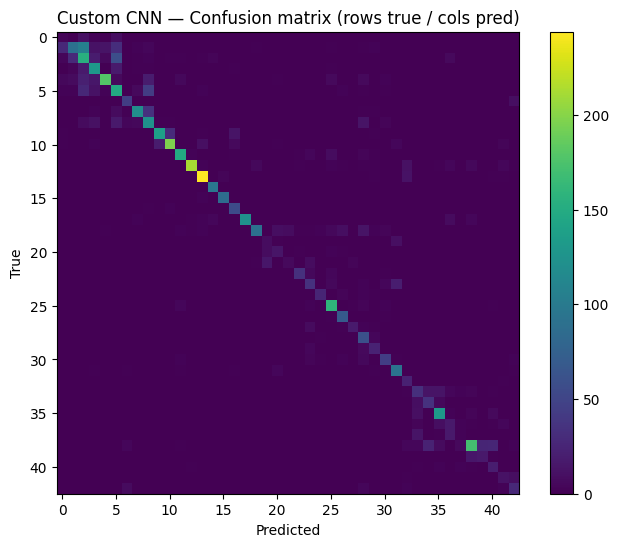

Saved custom model to custom_cnn_final.h5


In [13]:
# ====== Compile & train CUSTOM CNN ======
custom_model = build_custom_cnn()
custom_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

custom_model.summary()

callbacks_custom = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint('best_custom_cnn.h5', save_best_only=True, monitor='val_loss')
]

print("Training custom CNN...")
history_custom = custom_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks_custom,
    class_weight=class_weights
)

# Evaluate on test
print("Evaluating custom CNN on test set...")
test_loss, test_acc = custom_model.evaluate(test_ds)
print(f"Custom CNN test loss: {test_loss:.4f}  test acc: {test_acc:.4f}")

# Predictions and confusion matrix for custom
y_true = test_df['label'].values
y_pred_probs = custom_model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Custom model classification report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
plt.title("Custom CNN — Confusion matrix (rows true / cols pred)")
plt.imshow(cm, interpolation='nearest')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Save custom model
custom_model.save('custom_cnn_final.h5')
print("Saved custom model to custom_cnn_final.h5")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        55,083 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,313,067 (8.82 MB)

 Trainable params: 55,083 (215.17 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Training MobileNetV2 (base frozen)...
Epoch 1/25
    268/Unknown 52s 172ms/step - accuracy: 0.2465 - loss: 3.0514

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


268/268 ━━━━━━━━━━━━━━━━━━━━ 63s 213ms/step - accuracy: 0.2470 - loss: 3.0484 - val_accuracy: 0.6627 - val_loss: 1.0962
Epoch 2/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.5664 - loss: 1.3097

268/268 ━━━━━━━━━━━━━━━━━━━━ 55s 205ms/step - accuracy: 0.5665 - loss: 1.3095 - val_accuracy: 0.7531 - val_loss: 0.8155
Epoch 3/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.6403 - loss: 1.0578

268/268 ━━━━━━━━━━━━━━━━━━━━ 82s 205ms/step - accuracy: 0.6404 - loss: 1.0576 - val_accuracy: 0.7848 - val_loss: 0.6919
Epoch 4/25
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.6832 - loss: 0.9053

268/268 ━━━━━━━━━━━━━━━━━━━━ 81s 203ms/step - accuracy: 0.6833 - loss: 0.9052 - val_accuracy: 0.8107 - val_loss: 0.6267
Epoch 5/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.6972 - loss: 0.8341

268/268 ━━━━━━━━━━━━━━━━━━━━ 83s 310ms/step - accuracy: 0.6972 - loss: 0.8341 - val_accuracy: 0.8067 - val_loss: 0.6163
Epoch 6/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.7137 - loss: 0.7810

268/268 ━━━━━━━━━━━━━━━━━━━━ 113s 201ms/step - accuracy: 0.7137 - loss: 0.7810 - val_accuracy: 0.8302 - val_loss: 0.5469
Epoch 7/25
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.7246 - loss: 0.7690

268/268 ━━━━━━━━━━━━━━━━━━━━ 84s 208ms/step - accuracy: 0.7246 - loss: 0.7688 - val_accuracy: 0.8269 - val_loss: 0.5357
Epoch 8/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.7300 - loss: 0.7300

268/268 ━━━━━━━━━━━━━━━━━━━━ 81s 204ms/step - accuracy: 0.7300 - loss: 0.7301 - val_accuracy: 0.8408 - val_loss: 0.5181
Epoch 9/25
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.7387 - loss: 0.7151

268/268 ━━━━━━━━━━━━━━━━━━━━ 55s 206ms/step - accuracy: 0.7387 - loss: 0.7151 - val_accuracy: 0.8421 - val_loss: 0.5065
Epoch 10/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.7376 - loss: 0.6987

268/268 ━━━━━━━━━━━━━━━━━━━━ 56s 208ms/step - accuracy: 0.7376 - loss: 0.6987 - val_accuracy: 0.8438 - val_loss: 0.4919
Epoch 11/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.7380 - loss: 0.6953

268/268 ━━━━━━━━━━━━━━━━━━━━ 55s 204ms/step - accuracy: 0.7380 - loss: 0.6953 - val_accuracy: 0.8414 - val_loss: 0.4837
Epoch 12/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 56s 208ms/step - accuracy: 0.7382 - loss: 0.6799 - val_accuracy: 0.8395 - val_loss: 0.4856
Epoch 13/25
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.7494 - loss: 0.6566

268/268 ━━━━━━━━━━━━━━━━━━━━ 56s 209ms/step - accuracy: 0.7494 - loss: 0.6566 - val_accuracy: 0.8517 - val_loss: 0.4810
Epoch 14/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.7409 - loss: 0.6772

268/268 ━━━━━━━━━━━━━━━━━━━━ 141s 432ms/step - accuracy: 0.7409 - loss: 0.6772 - val_accuracy: 0.8514 - val_loss: 0.4633
Epoch 15/25
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.7469 - loss: 0.6620

268/268 ━━━━━━━━━━━━━━━━━━━━ 55s 206ms/step - accuracy: 0.7469 - loss: 0.6620 - val_accuracy: 0.8567 - val_loss: 0.4537
Epoch 16/25
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.7579 - loss: 0.6445

268/268 ━━━━━━━━━━━━━━━━━━━━ 55s 205ms/step - accuracy: 0.7579 - loss: 0.6444 - val_accuracy: 0.8603 - val_loss: 0.4432
Epoch 17/25
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7592 - loss: 0.6343

268/268 ━━━━━━━━━━━━━━━━━━━━ 57s 212ms/step - accuracy: 0.7592 - loss: 0.6343 - val_accuracy: 0.8626 - val_loss: 0.4364
Epoch 18/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 55s 204ms/step - accuracy: 0.7574 - loss: 0.6321 - val_accuracy: 0.8573 - val_loss: 0.4436
Epoch 19/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.7593 - loss: 0.6446

268/268 ━━━━━━━━━━━━━━━━━━━━ 87s 326ms/step - accuracy: 0.7593 - loss: 0.6446 - val_accuracy: 0.8613 - val_loss: 0.4345
Epoch 20/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 58s 215ms/step - accuracy: 0.7568 - loss: 0.6307 - val_accuracy: 0.8530 - val_loss: 0.4405
Epoch 21/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.7575 - loss: 0.6288

268/268 ━━━━━━━━━━━━━━━━━━━━ 74s 277ms/step - accuracy: 0.7575 - loss: 0.6288 - val_accuracy: 0.8620 - val_loss: 0.4229
Epoch 22/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.7625 - loss: 0.6196

268/268 ━━━━━━━━━━━━━━━━━━━━ 65s 241ms/step - accuracy: 0.7625 - loss: 0.6196 - val_accuracy: 0.8646 - val_loss: 0.4037
Epoch 23/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 73s 208ms/step - accuracy: 0.7603 - loss: 0.6400 - val_accuracy: 0.8666 - val_loss: 0.4088
Epoch 24/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 55s 203ms/step - accuracy: 0.7627 - loss: 0.6215 - val_accuracy: 0.8500 - val_loss: 0.4400
Epoch 25/25
268/268 ━━━━━━━━━━━━━━━━━━━━ 55s 206ms/step - accuracy: 0.7558 - loss: 0.6304 - val_accuracy: 0.8636 - val_loss: 0.4154
Evaluating MobileNetV2 on test set (base frozen)...
76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 175ms/step - accuracy: 0.7539 - loss: 0.7806
MobileNetV2 test loss: 0.7808  test acc: 0.7524
76/76 ━━━━━━━━━━━━━━━━━━━━ 25s 179ms/step
MobileNetV2 classification report (base frozen):
              precision    recall  f1-score   support

        3.29       0.21      0.40      0.27        25
        3.29       0.82      0.64      0.72       292
        3.29       0.56      0.50      0.53       286


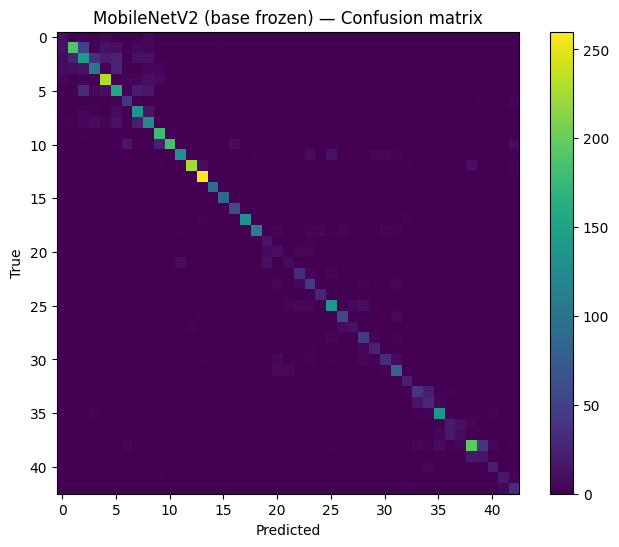

In [14]:
# ====== Compile & train MobileNetV2 (transfer learning) ======
mobile_model, mobile_base = build_mobilenetv2(base_trainable=False)
mobile_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
mobile_model.summary()

callbacks_mobile = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint('best_mobilenetv2.h5', save_best_only=True, monitor='val_loss')
]

print("Training MobileNetV2 (base frozen)...")
history_mobile = mobile_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks_mobile,
    class_weight=class_weights
)

# Evaluate
print("Evaluating MobileNetV2 on test set (base frozen)...")
t_loss, t_acc = mobile_model.evaluate(test_ds)
print(f"MobileNetV2 test loss: {t_loss:.4f}  test acc: {t_acc:.4f}")

y_pred_probs_m = mobile_model.predict(test_ds)
y_pred_m = np.argmax(y_pred_probs_m, axis=1)
print("MobileNetV2 classification report (base frozen):")
print(classification_report(y_true, y_pred_m, target_names=class_names, zero_division=0))

cm_m = confusion_matrix(y_true, y_pred_m)
plt.figure(figsize=(8,6))
plt.title("MobileNetV2 (base frozen) — Confusion matrix")
plt.imshow(cm_m, interpolation='nearest')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Starting fine-tuning: unfreeze top layers and retrain with lower LR...
Epoch 1/10
    268/Unknown 85s 193ms/step - accuracy: 0.3720 - loss: 4.2440

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


268/268 ━━━━━━━━━━━━━━━━━━━━ 95s 231ms/step - accuracy: 0.3722 - loss: 4.2407 - val_accuracy: 0.8169 - val_loss: 0.5507
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 77s 216ms/step - accuracy: 0.5457 - loss: 1.9549 - val_accuracy: 0.8156 - val_loss: 0.5794
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 84s 313ms/step - accuracy: 0.6264 - loss: 1.4057 - val_accuracy: 0.8199 - val_loss: 0.5738
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.6727 - loss: 1.1279

268/268 ━━━━━━━━━━━━━━━━━━━━ 60s 224ms/step - accuracy: 0.6727 - loss: 1.1276 - val_accuracy: 0.8332 - val_loss: 0.5234
Epoch 5/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.7015 - loss: 0.9580

268/268 ━━━━━━━━━━━━━━━━━━━━ 81s 221ms/step - accuracy: 0.7015 - loss: 0.9579 - val_accuracy: 0.8553 - val_loss: 0.4562
Epoch 6/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.7368 - loss: 0.7971

268/268 ━━━━━━━━━━━━━━━━━━━━ 81s 218ms/step - accuracy: 0.7368 - loss: 0.7970 - val_accuracy: 0.8669 - val_loss: 0.4119
Epoch 7/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.7520 - loss: 0.7227

268/268 ━━━━━━━━━━━━━━━━━━━━ 82s 307ms/step - accuracy: 0.7521 - loss: 0.7226 - val_accuracy: 0.8805 - val_loss: 0.3607
Epoch 8/10
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.7744 - loss: 0.6171

268/268 ━━━━━━━━━━━━━━━━━━━━ 117s 213ms/step - accuracy: 0.7744 - loss: 0.6171 - val_accuracy: 0.8931 - val_loss: 0.3219
Epoch 9/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.7983 - loss: 0.5534

268/268 ━━━━━━━━━━━━━━━━━━━━ 85s 226ms/step - accuracy: 0.7983 - loss: 0.5533 - val_accuracy: 0.9017 - val_loss: 0.2867
Epoch 10/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8002 - loss: 0.5179

268/268 ━━━━━━━━━━━━━━━━━━━━ 82s 306ms/step - accuracy: 0.8003 - loss: 0.5178 - val_accuracy: 0.9053 - val_loss: 0.2743
Evaluating fine-tuned MobileNetV2 on test set...
76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 168ms/step - accuracy: 0.8039 - loss: 0.6967
Fine-tuned MobileNetV2 test loss: 0.6718  test acc: 0.8024
76/76 ━━━━━━━━━━━━━━━━━━━━ 15s 179ms/step
MobileNetV2 (fine-tuned) classification report:
              precision    recall  f1-score   support

        3.29       0.39      0.28      0.33        25
        3.29       0.87      0.68      0.76       292
        3.29       0.68      0.67      0.67       286
        3.29       0.62      0.67      0.64       173
        3.29       0.79      0.90      0.84       272
        3.29       0.69      0.66      0.67       248
         3.3       0.89      0.77      0.83        53
        3.29       0.69      0.89      0.77       168
        3.29       0.69      0.62      0.65       185
        3.25       0.97      0.91      0.94       184
        3.2

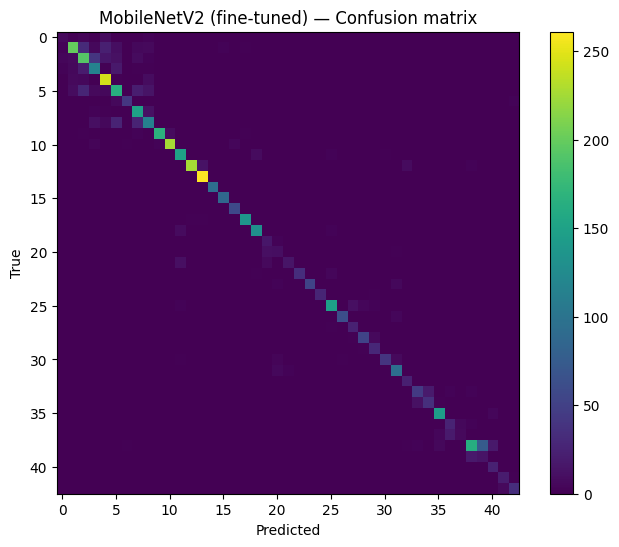

Saved MobileNetV2 final model to mobilenetv2_final.h5


In [15]:
# ====== fine-tune top layers of MobileNet ======
print("Starting fine-tuning: unfreeze top layers and retrain with lower LR...")
mobile_base.trainable = True
# Freeze first N layers, unfreeze the rest (tune N as experiment). We'll unfreeze from layer 100 onward.
fine_tune_at = 100
for layer in mobile_base.layers[:fine_tune_at]:
    layer.trainable = False
for layer in mobile_base.layers[fine_tune_at:]:
    layer.trainable = True

mobile_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_ft = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint('best_mobilenetv2_finetuned.h5', save_best_only=True, monitor='val_loss')
]

history_ft = mobile_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=FINE_TUNE_EPOCHS,
    callbacks=callbacks_ft,
    class_weight=class_weights
)

# Evaluate fine-tuned model
print("Evaluating fine-tuned MobileNetV2 on test set...")
t_loss_ft, t_acc_ft = mobile_model.evaluate(test_ds)
print(f"Fine-tuned MobileNetV2 test loss: {t_loss_ft:.4f}  test acc: {t_acc_ft:.4f}")

y_pred_probs_m_ft = mobile_model.predict(test_ds)
y_pred_m_ft = np.argmax(y_pred_probs_m_ft, axis=1)
print("MobileNetV2 (fine-tuned) classification report:")
print(classification_report(y_true, y_pred_m_ft, target_names=class_names, zero_division=0))

cm_m_ft = confusion_matrix(y_true, y_pred_m_ft)
plt.figure(figsize=(8,6))
plt.title("MobileNetV2 (fine-tuned) — Confusion matrix")
plt.imshow(cm_m_ft, interpolation='nearest')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Save final mobile model
mobile_model.save('mobilenetv2_final.h5')
print("Saved MobileNetV2 final model to mobilenetv2_final.h5")

In [16]:
# ====== Summary output ======
print("=== SUMMARY ===")
print(f"Custom CNN test acc: {test_acc:.4f}")
print(f"MobileNetV2 (frozen) test acc: {t_acc:.4f}")
print(f"MobileNetV2 (fine-tuned) test acc: {t_acc_ft:.4f}")
print("Models saved in the notebook working directory. Copy to Drive if desired.")

# Optionally copy to Drive
try:
    from google.colab import drive as drive
    drive_mounted = len(drive.mounts) > 0
except Exception:
    drive_mounted = False

if drive_mounted:
    drive_root = "/content/drive/MyDrive/traffic_sign_recognition"
    os.makedirs(os.path.join(drive_root, "gtsrb_models"), exist_ok=True)
    os.replace('custom_cnn_final.h5', os.path.join(drive_root, 'gtsrb_models', 'custom_cnn_final.h5'))
    os.replace('mobilenetv2_final.h5', os.path.join(drive_root, 'gtsrb_models', 'mobilenetv2_final.h5'))
    print("Saved models to your Drive -> gtsrb_models/")
else:
    print("Drive not mounted. If you want to save models to Drive, mount it and move the .h5 files.")

=== SUMMARY ===
Custom CNN test acc: 0.7118
MobileNetV2 (frozen) test acc: 0.7524
MobileNetV2 (fine-tuned) test acc: 0.8024
Models saved in the notebook working directory. Copy to Drive if desired.
Drive not mounted. If you want to save models to Drive, mount it and move the .h5 files.


In [38]:
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

model = load_model("mobilenetv2_final.h5", custom_objects={'preprocess_input': preprocess_input})


Saving 00007_00002_00023(1).png to 00007_00002_00023(1).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


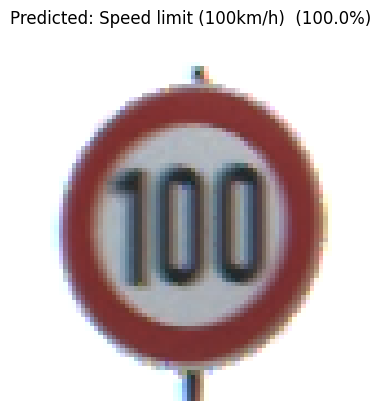

Predicted: Class 7 → Speed limit (100km/h) | Confidence: 99.98%
Top-3:
  Speed limit (100km/h)                99.98%
  Speed limit (120km/h)                 0.01%
  Speed limit (30km/h)                  0.01%


In [42]:
# --- Inference on uploaded image(s) with automatic input size and preprocessing handling ---

import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab import files
import tensorflow as tf

# If you haven't loaded your model yet, uncomment and load it here:
# from tensorflow.keras.models import load_model
# from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
# model = load_model("best_mobilenetv2_finetuned.h5", custom_objects={'preprocess_input': tf.keras.applications.mobilenet_v2.preprocess_input}, compile=False)

# 1) Auto-detect the model input size (H, W)
input_shape = model.input_shape
# Some models return a list of shapes; pick the first
if isinstance(input_shape, (list, tuple)) and isinstance(input_shape[0], (list, tuple)):
    input_shape = input_shape[0]
_, H, W, C = input_shape
if H is None or W is None or C != 3:
    raise ValueError(f"Unexpected model.input_shape: {model.input_shape}")

IMG_SIZE = (W, H)  # cv2.resize expects (width, height)

# 2) Decide whether to apply preprocess_input outside the model
#    If you had to pass custom_objects={'preprocess_input': ...} when loading,
#    that usually means the model ALREADY includes preprocessing internally.
#    Default below assumes preprocess is INSIDE the model. Flip to False if needed.
HAS_PREPROCESS_IN_MODEL = True

# 3) GTSRB label map (43 classes). If your dataset differs, we’ll fall back to "Class i".
id_to_sign_default = {
    0: "Speed limit (20km/h)",
    1: "Speed limit (30km/h)",
    2: "Speed limit (50km/h)",
    3: "Speed limit (60km/h)",
    4: "Speed limit (70km/h)",
    5: "Speed limit (80km/h)",
    6: "End of speed limit (80km/h)",
    7: "Speed limit (100km/h)",
    8: "Speed limit (120km/h)",
    9: "No passing",
    10: "No passing for >3.5t",
    11: "Right-of-way",
    12: "Priority road",
    13: "Yield",
    14: "Stop",
    15: "No vehicles",
    16: ">3.5t prohibited",
    17: "No entry",
    18: "General caution",
    19: "Left curve",
    20: "Right curve",
    21: "Double curve",
    22: "Bumpy road",
    23: "Slippery road",
    24: "Road narrows right",
    25: "Road work",
    26: "Traffic signals",
    27: "Pedestrians",
    28: "Children crossing",
    29: "Bicycles crossing",
    30: "Ice/Snow",
    31: "Wild animals",
    32: "End of all limits",
    33: "Turn right ahead",
    34: "Turn left ahead",
    35: "Ahead only",
    36: "Go straight or right",
    37: "Go straight or left",
    38: "Keep right",
    39: "Keep left",
    40: "Roundabout",
    41: "End no passing",
    42: "End no passing >3.5t",
}

# If you already defined `id_to_sign` earlier, we’ll use it; otherwise fall back to default.
try:
    id_to_sign  # noqa
except NameError:
    id_to_sign = id_to_sign_default

# Optional: warn if output classes != mapping size (only a warning; we’ll still show "Class i" safely)
num_outputs = model.output_shape[-1]
if num_outputs != len(id_to_sign):
    print(f"⚠️ Model outputs {num_outputs} classes, but id_to_sign has {len(id_to_sign)} entries. "
          f"Will fall back to 'Class i' if missing.")

# 4) Upload and predict
uploaded = files.upload()

# If we need external preprocessing (i.e., NOT inside the model), import it once
if not HAS_PREPROCESS_IN_MODEL:
    from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

for fn in uploaded.keys():
    img_path = fn

    # Read image (BGR), convert to RGB
    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        print(f"Could not read image: {img_path}")
        continue

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Resize to model's expected size
    img_resized = cv2.resize(img_rgb, IMG_SIZE)

    # Build batch of 1
    x = np.expand_dims(img_resized.astype(np.float32), axis=0)

    # Apply external preprocessing only if the model does NOT already include it
    if not HAS_PREPROCESS_IN_MODEL:
        x = preprocess_input(x)  # scales to [-1, 1] for MobileNetV2

    # Predict
    probs = model.predict(x)
    pred_class = int(np.argmax(probs, axis=1)[0])
    confidence = float(np.max(probs, axis=1)[0])

    # Title: predicted class name if available
    label_name = id_to_sign.get(pred_class, f"Class {pred_class}")

    # Show image + prediction
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title(f"Predicted: {label_name}  ({confidence*100:.1f}%)")
    plt.show()

    print(f"Predicted: Class {pred_class} → {label_name} | Confidence: {confidence*100:.2f}%")

    # Also print top-3 predictions
    top3_idx = probs[0].argsort()[-3:][::-1]
    print("Top-3:")
    for i in top3_idx:
        name = id_to_sign.get(int(i), f"Class {int(i)}")
        print(f"  {name:35s} {probs[0][i]*100:6.2f}%")